# Lab | Random Forests

For this lab, you will be using the CSV files provided in the `files_for_lab` folder.

### Instructions

- Apply the Random Forests algorithm but this time only by upscaling the data.
- Discuss the output and its impact in the bussiness scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the bussiness?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import make_scorer, f1_score, cohen_kappa_score, recall_score
from sklearn.utils import resample

pd.options.display.max_columns = None

#### Load data

In [2]:
numerical   = pd.read_csv('files_for_lab/numerical.csv')
categorical = pd.read_csv('files_for_lab/categorical.csv')
target      = pd.read_csv('files_for_lab/target.csv')

#### Column "TARGET_B" encodes if the customer answered or not the call


In [3]:
target['TARGET_B'].value_counts(dropna=False)

0    90569
1     4843
Name: TARGET_B, dtype: int64

We heave huge imbalance here

#### Encode categoricals since upsampling with SMOTE requires numericals

In [4]:
categorical_encoded = pd.get_dummies(categorical, drop_first=True)
data = pd.concat([numerical, categorical_encoded, target], axis=1)

#### Upsampling target column to get rid of imbalance

In [5]:
target_b_0 = data[data['TARGET_B']==0]
target_b_1 = data[data['TARGET_B']==1]

target_b_1s = resample(target_b_1, replace=True, n_samples=len(target_b_0))
data = pd.concat([target_b_0, target_b_1s])

In [6]:
data['TARGET_B'].value_counts()

0    90569
1    90569
Name: TARGET_B, dtype: int64

#### X/y Split

In [7]:

X = data.drop(['TARGET_B', 'TARGET_D'], axis=1)
y = data['TARGET_B']

#### Train/Test Split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

#### Scale numerical data

In [9]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


#### Find best features for our model

In [10]:
kbest = SelectKBest(chi2, k=10) # Here we choose 10 best features so that is easier to analyze results later
kbest.fit(X_train, y_train)
X_new = kbest.transform(X_train)

In [11]:
best_cols = [X.columns[index] for index,value in enumerate(kbest.get_support().tolist()) if value == True]
print(best_cols)

['TCODE', 'POP901', 'POP902', 'POP903', 'HV1', 'HV2', 'MSA', 'IC2', 'IC5', 'CONTROLN']


#### Using GridSearchCV to obtain the best parameters for our model

In [12]:
def my_gridsearch(X, y, model, params, scorefunc=accuracy_score, cv=5, verbose=0):
    '''
    Applies a gridsearch cross validation.
    
    Args:
        X:       The independent variables
        y:       The dependent variable
        model:   Model to use
        params:  Hyperparameters for the model
        scorer:  Scoring function (default=accuracy_score)
        cv:      Number of folds (default=5)
        verbose: Verbosity level {0-3} (default=0)
    Return:
        The fitted GridSearchCV instance
    '''
    start_time = time.time()
    scorer = make_scorer(scorefunc)
    gs = GridSearchCV(estimator=model, param_grid=params, cv=cv,
                      verbose=verbose, scoring=scorer, n_jobs=-1)
    gs.fit(X, y)    
    s = f'{scorefunc=}'
    
    print(f"\033[1mScore-func\033[0m:  {s.split('=')[1].split(' ')[1]}")
    print(f'\033[1mBest score\033[0m:  {gs.best_score_}')
    print(f'\033[1mBest params\033[0m: {gs.best_params_}')
    print( "\033[1mTime needed\033[0m: {:.4f}".format(time.time() - start_time))
    
    return gs
    

In [13]:
params = {
    'criterion': ["gini", "entropy"],
    'max_depth': [5, None],
    'min_samples_leaf': [2,4]
}

gs = my_gridsearch(X_train[best_cols], y_train,
                   RandomForestClassifier(),
                   params, recall_score)

Score-func:  recall_score
Best score:  0.9996358066121049
Best params: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2}
Time needed: 483.4221


#### Predict TARGET_B

In [14]:
y_train_pred = gs.best_estimator_.predict(X_train[best_cols])
y_test_pred  = gs.best_estimator_.predict(X_test[best_cols])

#### Evaluate scores

In [15]:
print(f"Train recall: {recall_score(y_train, y_train_pred)}")
print(f"Test recall:  {recall_score(y_test, y_test_pred)}")

Train recall: 1.0
Test recall:  1.0


In [16]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     26927
           1       0.97      1.00      0.99     27415

    accuracy                           0.99     54342
   macro avg       0.99      0.99      0.99     54342
weighted avg       0.99      0.99      0.99     54342



#### Plot confusion matrix

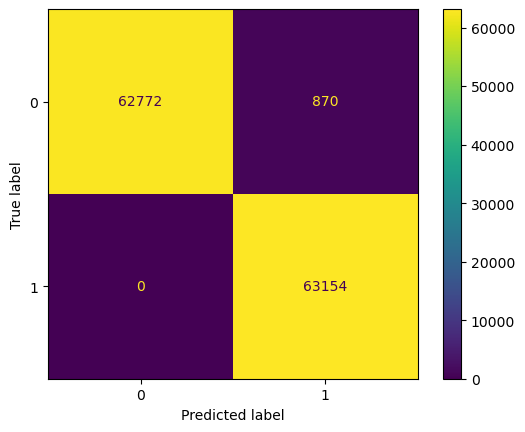

In [17]:
cm_train = confusion_matrix(y_train, y_train_pred)
ConfusionMatrixDisplay(cm_train, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

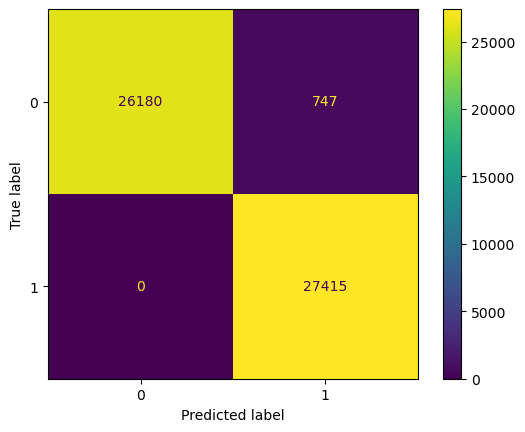

In [18]:
cm_test = confusion_matrix(y_test, y_test_pred)
ConfusionMatrixDisplay(cm_test, display_labels=gs.best_estimator_.classes_).plot()
plt.show()

#### Check if we get better results using kappa score

In [19]:
best_params = {
    'criterion': ['entropy'],
    'min_samples_leaf': [2],
    'min_samples_split': [2]
}

my_gridsearch(X_train[best_cols], y_train,
              RandomForestClassifier(),
              best_params, cohen_kappa_score)

Score-func:  cohen_kappa_score
Best score:  0.970790498085577
Best params: {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2}
Time needed: 165.0723


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'min_samples_leaf': [2],
                         'min_samples_split': [2]},
             scoring=make_scorer(cohen_kappa_score))

#### Check if we get better results using f1 score

In [20]:
my_gridsearch(X_train[best_cols], y_train,
              RandomForestClassifier(),
              best_params, f1_score)

Score-func:  f1_score
Best score:  0.9856765086363757
Best params: {'criterion': 'entropy', 'min_samples_leaf': 2, 'min_samples_split': 2}
Time needed: 164.0954


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'min_samples_leaf': [2],
                         'min_samples_split': [2]},
             scoring=make_scorer(f1_score))

### Conclusions

In my opinion, it would be better for the company to have a false negative than a false positive.
Since the average donation amount is 15.62€, the company will lose 15.62 times the number of false positive
dollar. On false negative, the company just loses the money for sending a letter...

In [21]:
target[target['TARGET_B']==1]['TARGET_D'].mean()

15.624344414619037